In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

from PIL import Image


In [ ]:
import kagglehub

path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [ ]:
def convert_to_df(path: str) -> pd.DataFrame:
  filepaths = []
  labels = []

  folds = os.listdir(path)

  for fold in folds:
    foldpath = os.path.join(path, fold)

    files = os.listdir(foldpath)
    for f in files:
        fpath = os.path.join(foldpath, f)

        filepaths.append(fpath)
        labels.append(fold)

  df = pd.DataFrame(data={'filepaths':filepaths, 'labels':labels})
  return df

In [ ]:
train_dir= path +"/Training"

test_dir = path + "/Testing"


train_df = convert_to_df(train_dir)
test_df = convert_to_df(test_dir)



In [ ]:
train_df["labels"].value_counts()

,count
labels,
notumor,1595
pituitary,1457
meningioma,1339
glioma,1321


In [ ]:
test_df["labels"].value_counts()

,count
labels,
notumor,405
meningioma,306
glioma,300
pituitary,300


In [ ]:
labels = list(test_df["labels"].value_counts().index)

In [ ]:
print(labels)

['notumor', 'meningioma', 'glioma', 'pituitary']


In [ ]:
train_count = train_df["labels"].value_counts()
test_count = test_df["labels"].value_counts()

counter = pd.merge(train_count, test_count, left_index=True, right_index=True)
counter.columns = ["train_count", "test_count"]
counter

,train_count,test_count
labels,,
notumor,1595,405
pituitary,1457,300
meningioma,1339,306
glioma,1321,300


In [ ]:
import seaborn as sns

In [ ]:
counter = counter.reset_index()

In [ ]:
def graph_amount_arser(df: pd.DataFrame, ax, column, offset=0):
  for i, v in enumerate(df[column]):
    plt.text(i+offset, v, str(v), ha='center', va='bottom')

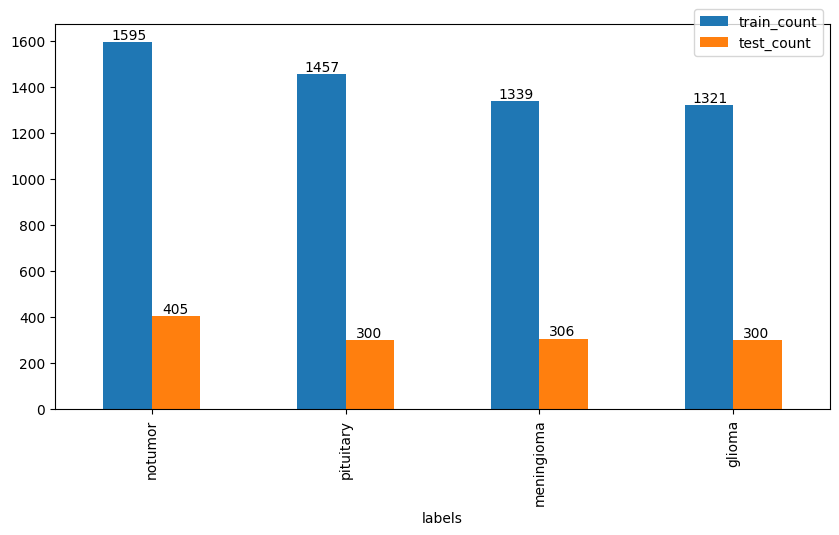

In [ ]:
ax = counter.plot(kind="bar", x="labels", y=["train_count", "test_count"], figsize=(10,5))
ax.legend(bbox_to_anchor=(1, 0.9),loc="lower right")


graph_amount_arser(counter, ax, "train_count", offset=-0.12)
graph_amount_arser(counter, ax, "test_count", offset=0.12)



plt.show()

In [ ]:
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [ ]:
resnet_target_size = (224, 224)
vgg19_target_size = (224, 224)

In [ ]:
print(train_df.head(10))

                                           filepaths  labels
0  /root/.cache/kagglehub/datasets/masoudnickparv...  glioma
1  /root/.cache/kagglehub/datasets/masoudnickparv...  glioma
2  /root/.cache/kagglehub/datasets/masoudnickparv...  glioma
3  /root/.cache/kagglehub/datasets/masoudnickparv...  glioma
4  /root/.cache/kagglehub/datasets/masoudnickparv...  glioma
5  /root/.cache/kagglehub/datasets/masoudnickparv...  glioma
6  /root/.cache/kagglehub/datasets/masoudnickparv...  glioma
7  /root/.cache/kagglehub/datasets/masoudnickparv...  glioma
8  /root/.cache/kagglehub/datasets/masoudnickparv...  glioma
9  /root/.cache/kagglehub/datasets/masoudnickparv...  glioma


In [ ]:
gen = ImageDataGenerator()



train_data = gen.flow_from_dataframe(train_df,
                                     x_col="filepaths",
                                     y_col="labels",
                                     target_size=resnet_target_size,
                                     class_mode="categorical",
                                     color_mode="rgb",
                                     batch_size=32)

Found 5712 validated image filenames belonging to 4 classes.


In [ ]:
!pip install resnet-pytorch

In [ ]:
from resnet_pytorch import ResNet
import torch

In [ ]:
model = ResNet.from_pretrained('resnet18', num_classes=4)

Loaded pretrained weights for resnet18.


In [ ]:
from torchvision import transforms


data_transforms = {
    "train": transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "val": transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class MRIDataset(Dataset):
  #Torch dataset.
  def __init__(self, df, label_mapping = {"glioma": 2, "meningioma": 1, "notumor": 0, "pituitary": 3}
,transforms=None):
    self.filepaths = df["filepaths"].values
    self.labels = df["labels"].values
    self.transforms = transforms
    self.label_mapping=label_mapping


  def __len__(self):
    return len(self.labels)


  def __getitem__(self, index):
    img_path = self.filepaths[index]
    label = self.labels[index]

    image = Image.open(img_path).convert("RGB")

    if not isinstance(label, torch.Tensor):
      label = self.label_mapping[label]
      label = torch.tensor(label, dtype=torch.long)

    if self.transforms:
      image = self.transforms(image)


    return image, label

In [ ]:
train_dataset = MRIDataset(train_df, transforms=data_transforms['train'])
val_dataset = MRIDataset(val_df, transforms=data_transforms['val'])

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
dataloaders = {"train": train_loader, "val": val_loader}
dataset_sizes = {"train": len(train_dataset), "val": len(val_dataset)}



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #GPU usage

In [ ]:
from torch import nn, optim

In [ ]:
!pip install torchmetrics --upgrade

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score, Accuracy, AUROC

In [ ]:
import torchmetrics

In [ ]:
num_classes = 4
train_metrics = {
    "accuracy": torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device),
    "precision": MulticlassPrecision(num_classes=num_classes, average="macro").to(device),
    "recall": MulticlassRecall(num_classes=num_classes, average="macro").to(device),
    "f1": MulticlassF1Score(num_classes=num_classes, average="macro").to(device),
}
val_metrics = {
    "accuracy": torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device),
    "precision": MulticlassPrecision(num_classes=num_classes, average="macro").to(device),
    "recall": MulticlassRecall(num_classes=num_classes, average="macro").to(device),
    "f1": MulticlassF1Score(num_classes=num_classes, average="macro").to(device),
}

In [ ]:
# Training loop
curr_metrics = []

num_epochs = 25
model.to(device)
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 10)
    current_epoch = {}
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
            metrics = train_metrics
        else:
            model.eval()
            metrics = val_metrics

        running_loss = 0.0
        for metric in metrics.values():
            metric.reset()


        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == "train":
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item() * inputs.size(0)


            for metric_name, metric in metrics.items():
                metric.update(preds, labels)

        iter_metrics = []
        epoch_loss = running_loss / dataset_sizes[phase]
        for name, metric in metrics.items():
            print(phase.capitalize())
            metric_value = metric.compute()
            curr = {f'{name.capitalize()}': metric_value}
            print(f"{name.capitalize()}: {metric_value:.4f}")
            metric.reset()

            iter_metrics.append(curr)

        current_epoch[phase] = iter_metrics
        curr_metrics.append(current_epoch)
        print()


        if phase == "train":
            scheduler.step()

print("Training complete.")

Epoch 1/25
----------
Train
Accuracy: 0.8023
Train
Precision: 0.8011
Train
Recall: 0.7972
Train
F1: 0.7982

Val
Accuracy: 0.8918
Val
Precision: 0.8907
Val
Recall: 0.8871
Val
F1: 0.8883

Epoch 2/25
----------
Train
Accuracy: 0.8960
Train
Precision: 0.8929
Train
Recall: 0.8928
Train
F1: 0.8928

Val
Accuracy: 0.9101
Val
Precision: 0.9113
Val
Recall: 0.9051
Val
F1: 0.9071

Epoch 3/25
----------
Train
Accuracy: 0.9165
Train
Precision: 0.9141
Train
Recall: 0.9139
Train
F1: 0.9140

Val
Accuracy: 0.9588
Val
Precision: 0.9584
Val
Recall: 0.9572
Val
F1: 0.9575

Epoch 4/25
----------
Train
Accuracy: 0.9277
Train
Precision: 0.9256
Train
Recall: 0.9253
Train
F1: 0.9255

Val
Accuracy: 0.9634
Val
Precision: 0.9624
Val
Recall: 0.9619
Val
F1: 0.9620

Epoch 5/25
----------
Train
Accuracy: 0.9384
Train
Precision: 0.9366
Train
Recall: 0.9360
Train
F1: 0.9363

Val
Accuracy: 0.9649
Val
Precision: 0.9637
Val
Recall: 0.9632
Val
F1: 0.9634

Epoch 6/25
----------
Train
Accuracy: 0.9473
Train
Precision: 0.9456
T

In [ ]:
torch.save(model.state_dict(), "resnet18_brain_tumor.pth")
print("Model state dictionary saved!")


Model state dictionary saved!


In [ ]:
print(len(curr_metrics))

50


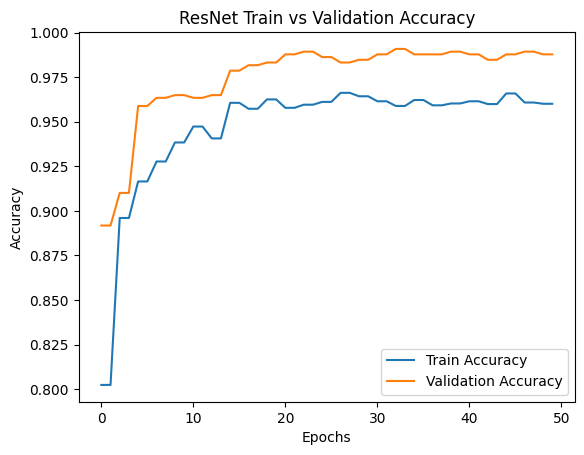

In [ ]:


# Extracting accuraccy to observe
train_accuracies = [epoch['train'][0]['Accuracy'].item() for epoch in curr_metrics]
val_accuracies = [epoch['val'][0]['Accuracy'].item() for epoch in curr_metrics]

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("ResNet Train vs Validation Accuracy")
plt.show()


In [ ]:
test_dataset = MRIDataset(test_df, transforms=data_transforms['val'])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score
import torch


num_classes = len(test_dataset.label_mapping)
test_metrics = {
    "accuracy": MulticlassAccuracy(num_classes=num_classes).to(device),
    "precision": MulticlassPrecision(num_classes=num_classes, average="macro").to(device),
    "recall": MulticlassRecall(num_classes=num_classes, average="macro").to(device),
    "f1": MulticlassF1Score(num_classes=num_classes, average="macro").to(device),
}

model.eval()
test_loss = 0.0
criterion = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)


        for metric_name, metric in test_metrics.items():
            metric.update(preds, labels)


test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

for name, metric in test_metrics.items():
    print(f"Test {name.capitalize()}: {metric.compute().item():.4f}")


Test Loss: 0.0525
Test Accuracy: 0.9782
Test Precision: 0.9806
Test Recall: 0.9782
Test F1: 0.9791


In [ ]:
from torchvision import models

model = models.vgg16(pretrained=True, )
num_ftrs = model.classifier[6].in_features
model.classifier[6] = torch.nn.Linear(num_ftrs, 4)

model = model.to(device)
print(model)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Training loop
curr_metrics = []

num_epochs = 25
model.to(device)
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 10)
    current_epoch = {}
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
            metrics = train_metrics
        else:
            model.eval()
            metrics = val_metrics

        running_loss = 0.0
        for metric in metrics.values():
            metric.reset()


        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == "train":
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item() * inputs.size(0)


            for metric_name, metric in metrics.items():
                metric.update(preds, labels)

        iter_metrics = []
        epoch_loss = running_loss / dataset_sizes[phase]
        for name, metric in metrics.items():
            print(phase.capitalize())
            metric_value = metric.compute()
            curr = {f'{name.capitalize()}': metric_value}
            print(f"{name.capitalize()}: {metric_value:.4f}")
            metric.reset()

            iter_metrics.append(curr)

        current_epoch[phase] = iter_metrics
        curr_metrics.append(current_epoch)
        print()


        if phase == "train":
            scheduler.step()

print("Training complete.")

Epoch 1/25
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train
Accuracy: 0.2222
Train
Precision: 0.2556
Train
Recall: 0.2268
Train
F1: 0.2106

Val
Accuracy: 0.1936
Val
Precision: 0.1428
Val
Recall: 0.2034
Val
F1: 0.1611

Epoch 2/25
----------
Train
Accuracy: 0.2181
Train
Precision: 0.2508
Train
Recall: 0.2228
Train
F1: 0.2082

Val
Accuracy: 0.1936
Val
Precision: 0.1428
Val
Recall: 0.2034
Val
F1: 0.1611

Epoch 3/25
----------
Train
Accuracy: 0.2260
Train
Precision: 0.2536
Train
Recall: 0.2304
Train
F1: 0.2146

Val
Accuracy: 0.1936
Val
Precision: 0.1428
Val
Recall: 0.2034
Val
F1: 0.1611

Epoch 4/25
----------
Train
Accuracy: 0.2243
Train
Precision: 0.2622
Train
Recall: 0.2276
Train
F1: 0.2124

Val
Accuracy: 0.1936
Val
Precision: 0.1428
Val
Recall: 0.2034
Val
F1: 0.1611

Epoch 5/25
----------
Train
Accuracy: 0.2206
Train
Precision: 0.2502
Train
Recall: 0.2251
Train
F1: 0.2109

Val
Accuracy: 0.1936
Val
Precision: 0.1428
Val
Recall: 0.2034
Val
F1: 0.1611

Epoch 6/25
----------
Train
Accuracy: 0.2206
Train
Precision: 0.2510
Train
Recall: 0.2248
Tr

In [ ]:
torch.save(model.state_dict(), "vgg16_brain_tumor.pth")
print("Model ağırlıkları başarıyla kaydedildi!")

Model ağırlıkları başarıyla kaydedildi!


In [ ]:
torch.save(model.state_dict(), "1_vgg16_brain_tumor.pth")
print("Model ağırlıkları başarıyla kaydedildi!")

Model ağırlıkları başarıyla kaydedildi!


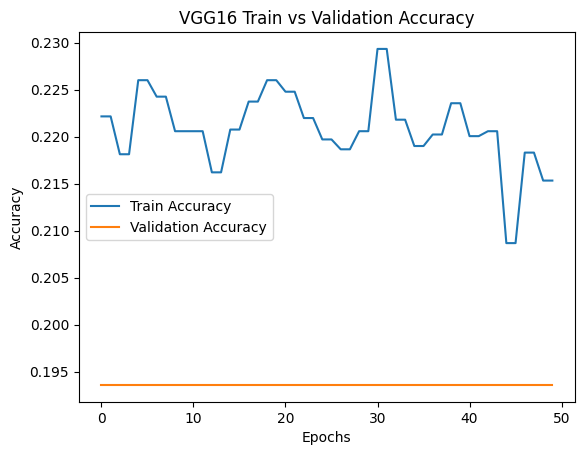

In [ ]:


# Extract and plot metrics
train_accuracies = [epoch['train'][0]['Accuracy'].item() for epoch in curr_metrics]
val_accuracies = [epoch['val'][0]['Accuracy'].item() for epoch in curr_metrics]

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("VGG16 Train vs Validation Accuracy")
plt.show()


In [ ]:
test_dataset = MRIDataset(test_df, transforms=data_transforms['val'])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)



In [ ]:
# The metrics for evaluation without emphasizing any label with using macro attr
num_classes = len(test_dataset.label_mapping)
test_metrics = {
    "accuracy": MulticlassAccuracy(num_classes=num_classes).to(device),
    "precision": MulticlassPrecision(num_classes=num_classes, average="macro").to(device),
    "recall": MulticlassRecall(num_classes=num_classes, average="macro").to(device),
    "f1": MulticlassF1Score(num_classes=num_classes, average="macro").to(device),
}


model.eval()
test_loss = 0.0
criterion = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)


        for metric_name, metric in test_metrics.items():
            metric.update(preds, labels)


test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

for name, metric in test_metrics.items():
    print(f"Test {name.capitalize()}: {metric.compute().item():.4f}")


Test Loss: 1.4431
Test Accuracy: 0.1809
Test Precision: 0.3774
Test Recall: 0.1809
Test F1: 0.1479


In [ ]:
from torchvision.models import mobilenet_v3_large
model = mobilenet_v3_large(pretrained=True)
print(model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_ftrs = model.classifier[3].in_features
model.classifier[3] = torch.nn.Linear(num_ftrs, 4)

model = model.to(device)
print(model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [ ]:

mobile_curr_metrics = []

num_epochs = 40
model.to(device)
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 10)
    current_epoch = {}
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
            metrics = train_metrics
        else:
            model.eval()
            metrics = val_metrics

        running_loss = 0.0
        for metric in metrics.values():
            metric.reset()


        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == "train":
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item() * inputs.size(0)


            for metric_name, metric in metrics.items():
                metric.update(preds, labels)

        iter_metrics = []
        epoch_loss = running_loss / dataset_sizes[phase]
        for name, metric in metrics.items():
            print(phase.capitalize())
            metric_value = metric.compute()
            curr = {f'{name.capitalize()}': metric_value}
            print(f"{name.capitalize()}: {metric_value:.4f}")
            metric.reset()

            iter_metrics.append(curr)

        current_epoch[phase] = iter_metrics
        mobile_curr_metrics.append(current_epoch)
        print()


        if phase == "train":
            scheduler.step()

print("Training complete.")

Epoch 1/40
----------
Train
Accuracy: 0.2383
Train
Precision: 0.2387
Train
Recall: 0.2381
Train
F1: 0.2383

Val
Accuracy: 0.1860
Val
Precision: 0.1614
Val
Recall: 0.1864
Val
F1: 0.1643

Epoch 2/40
----------
Train
Accuracy: 0.2446
Train
Precision: 0.2451
Train
Recall: 0.2449
Train
F1: 0.2449

Val
Accuracy: 0.2012
Val
Precision: 0.1738
Val
Recall: 0.2022
Val
F1: 0.1758

Epoch 3/40
----------
Train
Accuracy: 0.2428
Train
Precision: 0.2436
Train
Recall: 0.2431
Train
F1: 0.2433

Val
Accuracy: 0.2332
Val
Precision: 0.2077
Val
Recall: 0.2314
Val
F1: 0.2089

Epoch 4/40
----------
Train
Accuracy: 0.2390
Train
Precision: 0.2398
Train
Recall: 0.2397
Train
F1: 0.2396

Val
Accuracy: 0.3034
Val
Precision: 0.2622
Val
Recall: 0.3058
Val
F1: 0.2673

Epoch 5/40
----------
Train
Accuracy: 0.2493
Train
Precision: 0.2512
Train
Recall: 0.2494
Train
F1: 0.2503

Val
Accuracy: 0.2988
Val
Precision: 0.2687
Val
Recall: 0.3014
Val
F1: 0.2790

Epoch 6/40
----------
Train
Accuracy: 0.2271
Train
Precision: 0.2272
T

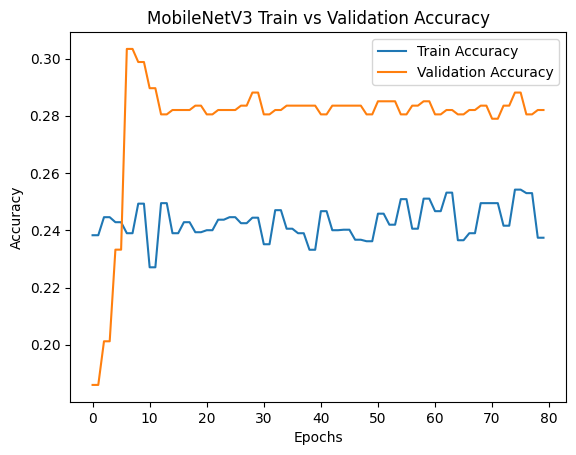

In [ ]:


train_accuracies = [epoch['train'][0]['Accuracy'].item() for epoch in mobile_curr_metrics]
val_accuracies = [epoch['val'][0]['Accuracy'].item() for epoch in mobile_curr_metrics]

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("MobileNetV3 Train vs Validation Accuracy")
plt.show()


In [ ]:
torch.save(model.state_dict(), "mobilenetV3_brain_tumor.pth")
print("Model ağırlıkları başarıyla kaydedildi!")

Model ağırlıkları başarıyla kaydedildi!


In [ ]:

num_classes = len(test_dataset.label_mapping)
test_metrics = {
    "accuracy": MulticlassAccuracy(num_classes=num_classes).to(device),
    "precision": MulticlassPrecision(num_classes=num_classes, average="macro").to(device),
    "recall": MulticlassRecall(num_classes=num_classes, average="macro").to(device),
    "f1": MulticlassF1Score(num_classes=num_classes, average="macro").to(device),
}


model.eval()
test_loss = 0.0
criterion = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)


        for metric_name, metric in test_metrics.items():
            metric.update(preds, labels)


test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

for name, metric in test_metrics.items():
    print(f"Test {name.capitalize()}: {metric.compute().item():.4f}")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Loss: 1.3959
Test Accuracy: 0.2995
Test Precision: 0.2743
Test Recall: 0.2995
Test F1: 0.2816
